# Displaying advantages of **PMM** (predictive mean matching) compared to 'standard' linear mean imputing

Source: https://www.statsmodels.org/dev/generated/statsmodels.imputation.mice.MICEData.html

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from statsmodels.imputation.mice import MICEData

### Data where X and Y can both be NaN at the same index

56 NaNs in x, 56 NaNs in y
x[0:5] = [ 2.73956049 -0.6112156          nan         nan         nan]
y[0:5] = [  45.79683799           nan   92.77833836           nan -154.39969158]


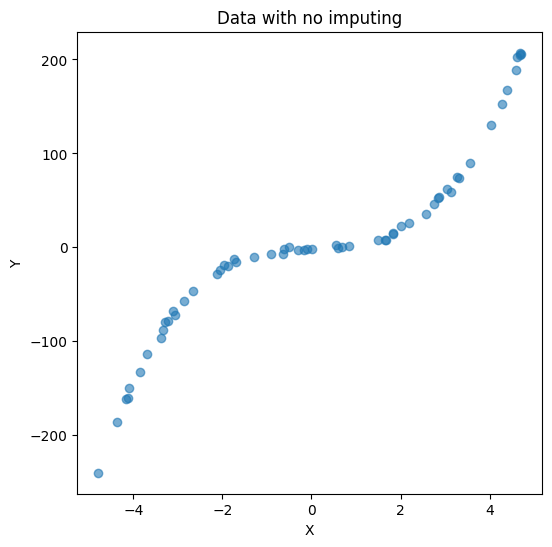

In [240]:
n_samples   = 150                    
coeffs      = (2, -0.4, 2.0, -1)
noise_std   = 3.0                    
p_nan_x     = 0.4
p_nan_y     = 0.4                 
rng         = np.random.default_rng(42)

x = rng.uniform(-5.0, 5.0, n_samples)

a3, a2, a1, a0 = coeffs
y_clean = a3*x**3 + a2*x**2 + a1*x + a0

y = y_clean + rng.normal(0.0, noise_std, n_samples)

mask_x = rng.random(n_samples) < p_nan_x
mask_y = rng.random(n_samples) < p_nan_y
x[mask_x] = np.nan
y[mask_y] = np.nan

print(f"{mask_x.sum()} NaNs in x, {mask_y.sum()} NaNs in y")
print("x[0:5] =", x[:5])
print("y[0:5] =", y[:5])

plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.6)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data with no imputing')
plt.show()

### Data with no rows having NaN for both x and y 

44 NaNs in x, 48 NaNs in y, 0 NaNs in both


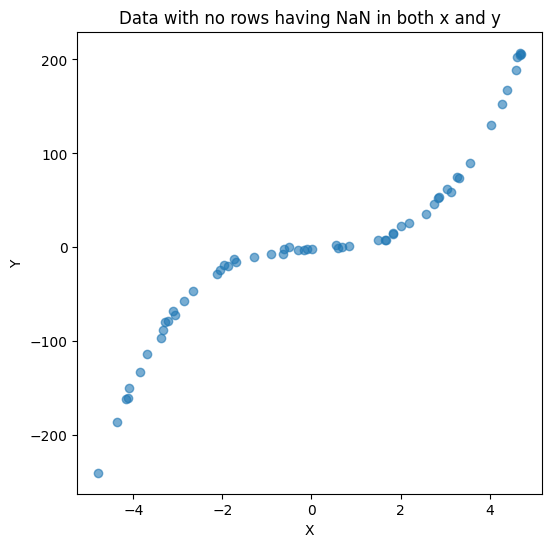

In [241]:
n_samples = 150
coeffs = (2, -0.4, 2.0, -1)
noise_std = 3.0
p_nan_x = 0.4
p_nan_y = 0.4
rng = np.random.default_rng(42)

x = rng.uniform(-5.0, 5.0, n_samples)

a3, a2, a1, a0 = coeffs
y_clean = a3*x**3 + a2*x**2 + a1*x + a0
y = y_clean + rng.normal(0.0, noise_std, n_samples)

mask_x = rng.random(n_samples) < p_nan_x
mask_y = rng.random(n_samples) < p_nan_y

both_nan = mask_x & mask_y

for i in np.where(both_nan)[0]:
    if rng.random() < 0.5:
        mask_y[i] = False  
    else:
        mask_x[i] = False  

x[mask_x] = np.nan
y[mask_y] = np.nan

print(f"{mask_x.sum()} NaNs in x, {mask_y.sum()} NaNs in y, {np.sum(mask_x & mask_y)} NaNs in both")

plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.6)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data with no rows having NaN in both x and y')
plt.show()

### Normal 'Linear' Imputation

In [242]:
X = np.column_stack((x, y))      
print(f"NaN Values before linear imputation: {np.isnan(X).sum()}") 

np.random.seed(0)                  
imputer = IterativeImputer(
    estimator=LinearRegression(),  
    initial_strategy="mean",
    imputation_order="random",    
    max_iter=10,                   
    random_state=0                
)

X_imputed = imputer.fit_transform(X)   
print(f"NaN Values after linear imputation: {np.isnan(X_imputed).sum()}")
x_imp, y_imp = X_imputed[:, 0], X_imputed[:, 1]

NaN Values before linear imputation: 92
NaN Values after linear imputation: 0


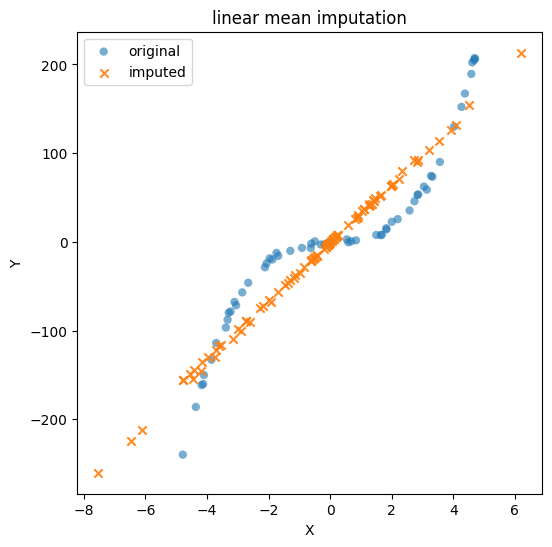

In [243]:
imputed_mask  = np.isnan(x) | np.isnan(y)  
original_mask = ~imputed_mask

plt.figure(figsize=(6, 6))
plt.scatter(
    x_imp[original_mask], y_imp[original_mask],
    alpha=0.6, label='original', edgecolor='none'
)
plt.scatter(
    x_imp[imputed_mask], y_imp[imputed_mask],
    alpha=0.9, marker='x', label='imputed'
)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('linear mean imputation')
plt.legend()
plt.show()

### PMM Imputation

MICE automatically drops rows where every column is NaN. This needs to be properly handled before applying PMM.

In [244]:
df = pd.DataFrame({'x': x, 'y': y})
print(f"NaN Values before PMM: {df.isnull().sum()}")

all_missing_mask = df.isnull().all(axis=1)
print(f"Rows with all NaNs: {all_missing_mask.sum()}") # == 20 when when using the first dataset
print(df[all_missing_mask])

imputed_mask = df.isna().any(axis=1)
original_mask = ~imputed_mask

original_index = df.index

mice = MICEData(df.copy(), k_pmm=5)
for _ in range(100):
    mice.update_all()

df_imp = mice.data
print(f"After MICE NaN counts:\n{df_imp.isnull().sum()}")
print(f"Original index length: {len(df.index)}")
print(f"Imputed data index length: {len(df_imp.index)}")

df_imp_partial = mice.data
df_imp_full = pd.DataFrame(index=original_index, columns=['x', 'y'])
df_imp_full.loc[df_imp_partial.index] = df_imp_partial
print(f"NaN Values: {df_imp_full.isnull().sum()}")

x_imp = df_imp_full['x'].to_numpy(dtype='float64')
y_imp = df_imp_full['y'].to_numpy(dtype='float64')

NaN Values before PMM: x    44
y    48
dtype: int64
Rows with all NaNs: 0
Empty DataFrame
Columns: [x, y]
Index: []
After MICE NaN counts:
x    0
y    0
dtype: int64
Original index length: 150
Imputed data index length: 150
NaN Values: x    0
y    0
dtype: int64


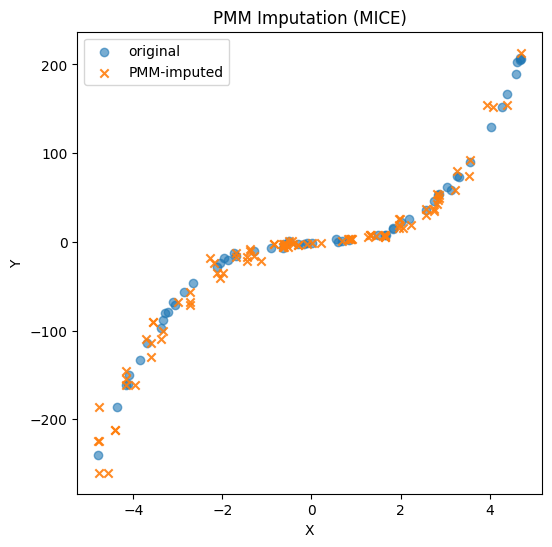

In [245]:
plt.figure(figsize=(6, 6))
plt.scatter(x_imp[original_mask], y_imp[original_mask],
            alpha=0.6, label='original')
plt.scatter(x_imp[imputed_mask], y_imp[imputed_mask],
            alpha=0.9, marker='x', label='PMM-imputed')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PMM Imputation (MICE)')
plt.legend()
plt.show()

In [246]:
df_imp_full.shape

(150, 2)

### Conclusion
Predictive Mean Matching (**PMM**) is a robust imputation technique, particularly wellsuited for datasets where *preserving the original data distribution* is critical. Unlike simpler linear methods such as mean or median imputation, **PMM** maintains the variability and relationships within the data, which is especially beneficial when preparing inputs for machine learning models. By drawing imputed values from observed data points with similar predictive characteristics, **PMM** *avoids introducing unrealistic or overly smoothed estimates*, helping models generalize better and reducing the risk of bias in downstream tasks.